In [24]:
import matplotlib
#import requests
import pandas
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7, 5)

#Connect to spark

In [25]:
from pandas import DataFrame
from scipy import special
from scipy import misc
from scipy.optimize import minimize
import math
from lifetimes.datasets import load_cdnow 
from lifetimes.estimation import BaseFitter,BetaGeoFitter,ModifiedBetaGeoFitter
from lifetimes.utils import _fit, _scale_time, _check_inputs, customer_lifetime_value
from lifetimes.generate_data import beta_geometric_nbd_model,modified_beta_geometric_nbd_model
from pyspark import SparkContext, SparkConf
from pyspark.sql import HiveContext
from pyspark.streaming import StreamingContext
from pyspark.sql.functions import udf
from pyspark.sql.functions import udf
from pyspark.sql.types import LongType
from pyspark.sql.functions import lit
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType, DoubleType, DecimalType, IntegerType
#from pyspark.sql.functions import isnan
from pyspark.sql import functions as func
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import *
import time
print('done')

done


In [26]:
sc.stop()

In [69]:
conf_start_time=time.time()
confList = [
    ["spark.streaming.unpersist", "true"]           # Automated memory management for Streaming apps
    ,["spark.executor.memory", "32g"]               # Amount of memory for each executor (shared by all tasks in the executor)
    ,["spark.mesos.coarse", "true"]                 # Accept and hold a fixed amount of resource from Mesos
    ,["spark.serializer","org.apache.spark.serializer.KryoSerializer"] #Define Kryo as Base Serializer
    ,["spark.kryoserializer.buffer","128k"]         #Define base memory per node
    ,["spark.kryoserializer.buffer.max.mb","2047"]  #Define max value that Kryo Serializer can run upto
    ,["spark.rdd.compress", "true"]                 # Enabling RDD compress to optimize storeage space
    ,["spark.cores.max", "64"]                      # Defines the number of cores
    ,["spark.akka.heartbeat.interval", "10000s"]     # Define hearbeat pulse interval
    ,["spark.akka.heartbeat.pauses", "15000s"]       # Define hearbeat wait time post interval, for which system waits for executor to reply

]

conf = SparkConf().setAppName("Random Forest - CLTV").setAll(confList)
sc = SparkContext(conf=conf)
sqlContext = HiveContext(sc)
conf_end_time=time.time()
conf_setup_time=conf_end_time-conf_start_time
print ("Took %.2f to setup start resources on Spark!" %conf_setup_time)

Took 3.06 to setup start resources on Spark!


#Get training data

In [72]:
tdf = sqlContext.sql('select * FROM covariates_weeks where tenure_score == 1').cache()
tdf.count()

808072

In [73]:
# define window
from pyspark.sql.functions import rand
w_order =  Window.partitionBy(tdf.tenure_score, tdf.frequency, tdf.r_weeks_int).orderBy(rand())
w_cnt = Window.partitionBy(tdf.tenure_score, tdf.frequency, tdf.r_weeks_int)

In [89]:
(tdf
 .groupby('tenure_score', 'frequency')
 .agg(count('ugc_id'))
 .head()
)

Row(tenure_score=5, frequency=380, count(ugc_id)=1)

In [99]:
df = (
    tdf
    .filter(tdf.tenure_score <= 12)
    #.filter(tdf.frequency == 1)
    .select(
    'tenure_score', "ugc_id", 'frequency',
    'r_weeks', 'r_weeks_int', 't_weeks',
    'freq_post', 'freq_post_98', 'clv.pred_exp_orders', 'clv.pred_exp_orders','tab_devices',
        'desktop_devices',
    count('ugid').over(w_cnt).alias("cust_cnt")
    )
    .withColumn('r', tdf.tenure_score - tdf.r_weeks)
     )

df = (df
      .filter(df.cust_cnt > 100)
      .filter(df.samp_rank <= 1000)
      .withColumn('pred_orders', (df.pred_exp_orders_mbg + df.pred_exp_orders_mbg)/2 )
     )

In [33]:
#df.count()

In [ ]:
data = df.toPandas()
data.to_csv('/home/covariate_clv.csv', index = None)
data.head()

In [101]:
sc.stop()

#Model

In [102]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn import cross_validation
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

In [103]:
rs = 1
estimators = 101
ests = [linear_model.LinearRegression(), 
        linear_model.Ridge(),
        linear_model.Lasso(), 
        linear_model.ElasticNet(),
        linear_model.BayesianRidge(), 
        linear_model.OrthogonalMatchingPursuit(),
        RandomForestRegressor(n_estimators=estimators),
        AdaBoostRegressor(n_estimators=estimators),
        GradientBoostingRegressor(n_estimators=estimators),
        BaggingRegressor(n_estimators=estimators)
        
       ]

ests = [RandomForestRegressor(n_estimators=estimators)]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP', 
                        'Random', 'Ada', 'Gb', 'Bag'
                       ])
errvals = np.array([])

In [104]:
features = ['tenure_score', 'frequency', 'r', 'pred_orders','tab_smartphone_arr','desktop_arr']
dep = ['freq_post']

In [105]:
X_train, X_test, y_train, y_test = train_test_split(data[features],
                                                    data.freq_post, test_size=0.2, random_state=20)

In [40]:
#y_train

In [106]:
for e in ests:
    print e
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    print "got Med error %0.2f" % this_err
    print "got Mean error %0.2f" % metrics.mean_absolute_error(y_test, e.predict(X_test))
    errvals = np.append(errvals, this_err)
    #break

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=101, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
got Med error 3.08
got Mean error 5.74


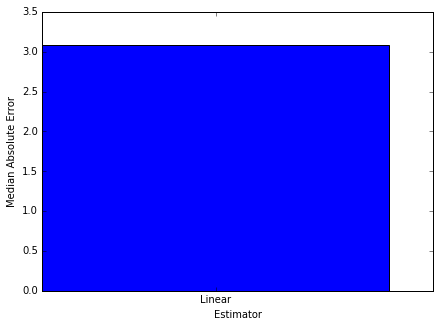

In [107]:
pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [ ]:
feature_importance = e.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

In [109]:
predicted_counts = e.predict(data[features])

In [110]:
data['rf_p'] = np.asarray(predicted_counts)

In [112]:
col_list = ['tenure_score', 'frequency', 'r_weeks_int', 
            'pred_orders', 'freq_post', 'rf_p' ]

(data[col_list]
 #.query('tenure_score == 3')
 #.query('freq_post > 0')
 #.groupby('r_weeks_int')
 .groupby([ 'tenure_score','frequency', 'r_weeks_int'])
 .agg(['mean', 'count'])
 .head(40))

pred_orders        freq_post        \
                                          mean count       mean count   
tenure_score frequency r_weeks_int                                      
5            1         0              1.393476  1000   1.176000  1000   
             2         0              5.014445  1000   1.987000  1000   
                       1              5.087724  1000   2.410000  1000   
                       2              5.226977  1000   3.016000  1000   
                       3              5.342588  1000   3.507000  1000   
                       4              5.449257  1000   3.896000  1000   
                       5              5.538120  1000   4.840000  1000   
             3         0              8.202870   902   1.815965   902   
                       1              8.425809  1000   3.356000  1000   
                       2              8.805604  1000   3.996000  1000   
                       3              9.106597  1000   4.915000  1000   
                       4              9.367647  1000   6.388000  1000   
                       5              9.587263  1000   6.903000  1000   
             4         0             10.982372   162   1.487654   162   
                       1             11.445998   576   4.425347   576   
                       2             12.183122   636   6.128931   636   
                       3             12.752563   683   6.745242   683   
                       4             13.222149   745   9.068456   745   
                       5             13.596587   987  10.535968   987   
             5         1             14.150408   169   3.443787   169   
                       2             15.375263   201   5.547264   201   
                       3             16.330831   247   7.295547   247   
                       4             17.037117   307  11.133550   307   
                       5             17.599746   455  13.740659   455   
             6         4             20.845569   135  10.207407   135   
                       5             21.579058   204  17.539216   204   
             7         5             25.516617   136  15.698529   136   

                                         rf_p        
                                         mean count  
tenure_score frequency r_weeks_int                   
5            1         0             1.166597  1000  
             2         0             1.902135  1000  
                       1             2.497899  1000  
                       2             3.032215  1000  
                       3             3.493863  1000  
                       4             3.812720  1000  
                       5             4.858782  1000  
             3         0             1.828145   902  
                       1             3.324872  1000  
                       2             3.978040  1000  
                       3             5.069710  1000  
                       4             6.620358  1000  
                       5             7.214324  1000  
             4         0             1.601983   162  
                       1             4.603980   576  
                       2             6.258717   636  
                       3             6.850592   683  
                       4             9.146910   745  
                       5             9.946359   987  
             5         1             3.970389   169  
                       2             5.521754   201  
                       3             7.795032   247  
                       4            10.005965   307  
                       5            12.912577   455  
             6         4            11.481479   135  
                       5            17.168036   204  
             7         5            16.453111   136

In [113]:
data_rft = pd.DataFrame(data.groupby(['tenure_score','frequency','r_weeks'],
                                                          as_index=False)['pred_orders','freq_post','rf_p'].mean())

data_rft.head(2)

,tenure_score,frequency,r_weeks,pred_orders,freq_post,rf_p
0,5,1,0.0,1.393476,1.176,1.166597
1,5,2,0.0,5.014445,1.987,1.902135


frequency
2    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
4    Axes(0.125,0.125;0.775x0.775)
5    Axes(0.125,0.125;0.775x0.775)
6    Axes(0.125,0.125;0.775x0.775)
7    Axes(0.125,0.125;0.775x0.775)
dtype: object

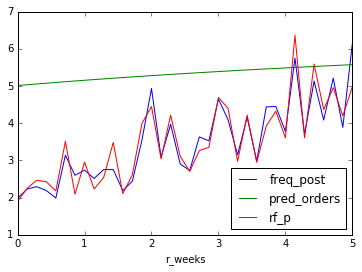

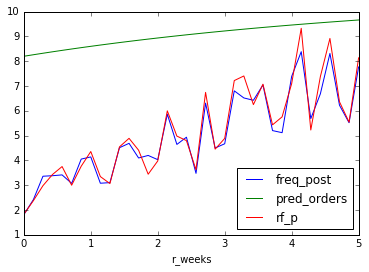

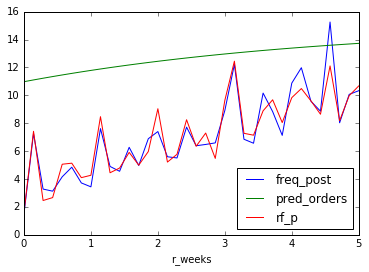

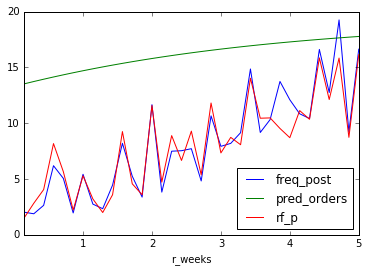

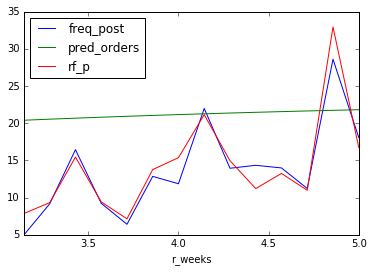

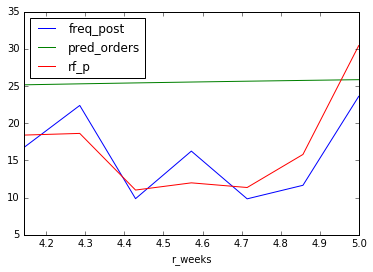

In [114]:
%matplotlib inline
#plot for app users
(data_rft
#.query('tenure_score == 4')
.query('frequency > 1')
.groupby('frequency')
.plot(x = 'r_weeks', y = ['freq_post', 'pred_orders','rf_p'], by = 'frequency')
)

/home/nvishw2/bfd-jupyter/venv/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


r_weeks
0.000000    Axes(0.125,0.125;0.775x0.775)
0.142857    Axes(0.125,0.125;0.775x0.775)
0.285714    Axes(0.125,0.125;0.775x0.775)
0.428571    Axes(0.125,0.125;0.775x0.775)
0.571429    Axes(0.125,0.125;0.775x0.775)
0.714286    Axes(0.125,0.125;0.775x0.775)
0.857143    Axes(0.125,0.125;0.775x0.775)
1.000000    Axes(0.125,0.125;0.775x0.775)
1.142857    Axes(0.125,0.125;0.775x0.775)
1.285714    Axes(0.125,0.125;0.775x0.775)
1.428571    Axes(0.125,0.125;0.775x0.775)
1.571429    Axes(0.125,0.125;0.775x0.775)
1.714286    Axes(0.125,0.125;0.775x0.775)
1.857143    Axes(0.125,0.125;0.775x0.775)
2.000000    Axes(0.125,0.125;0.775x0.775)
2.142857    Axes(0.125,0.125;0.775x0.775)
2.285714    Axes(0.125,0.125;0.775x0.775)
2.428571    Axes(0.125,0.125;0.775x0.775)
2.571429    Axes(0.125,0.125;0.775x0.775)
2.714286    Axes(0.125,0.125;0.775x0.775)
2.857143    Axes(0.125,0.125;0.775x0.775)
3.000000    Axes(0.125,0.125;0.775x0.775)
3.142857    Axes(0.125,0.125;0.775x0.775)
3.285714    Axes(0.125,0.1

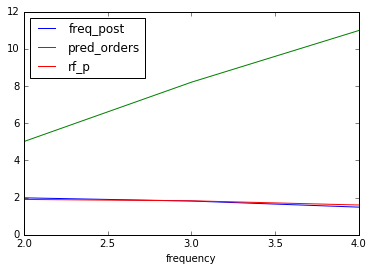

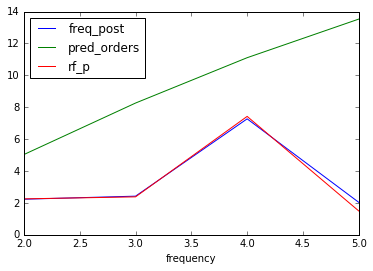

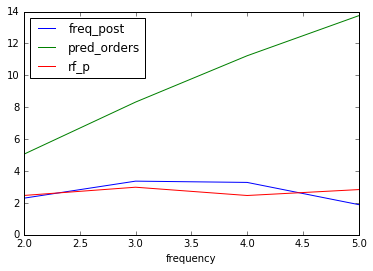

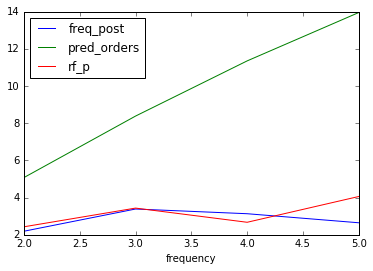

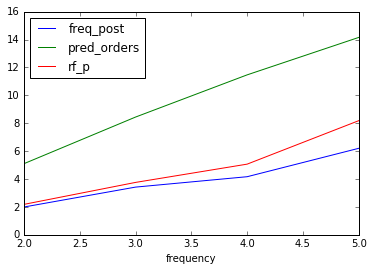

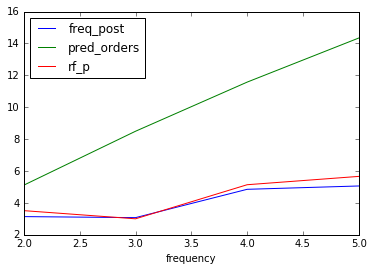

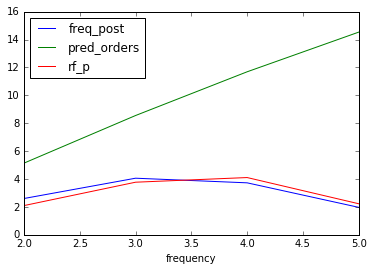

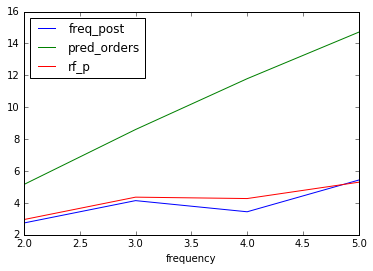

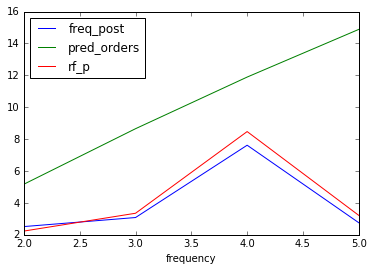

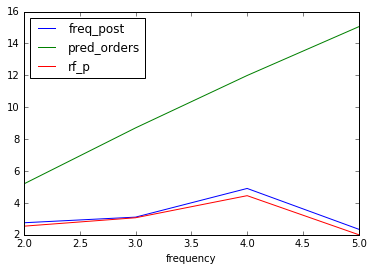

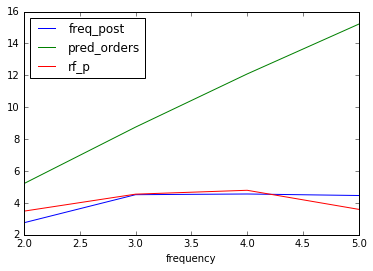

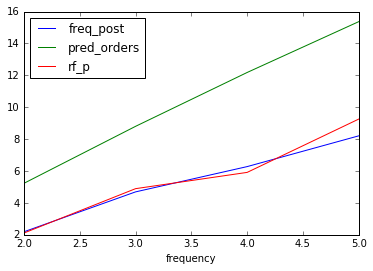

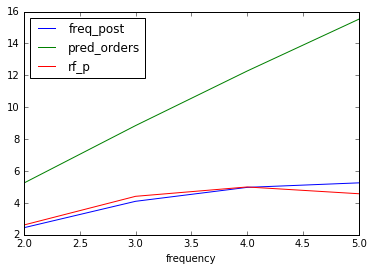

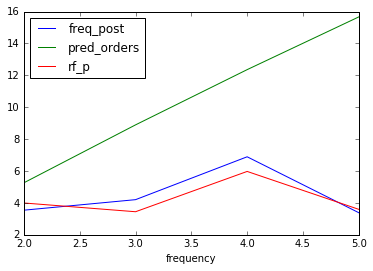

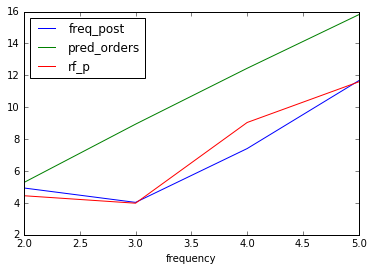

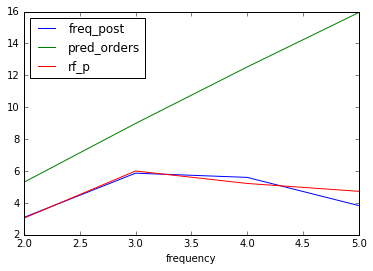

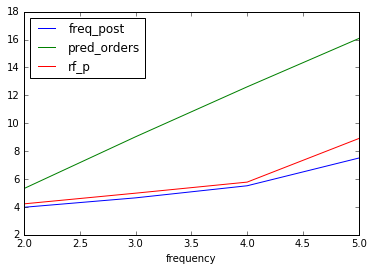

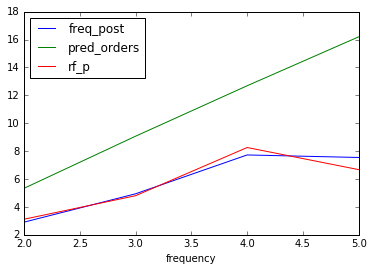

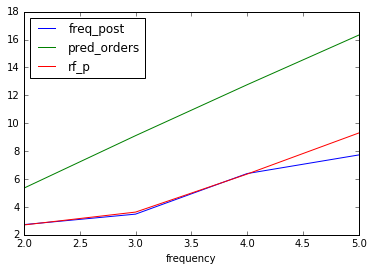

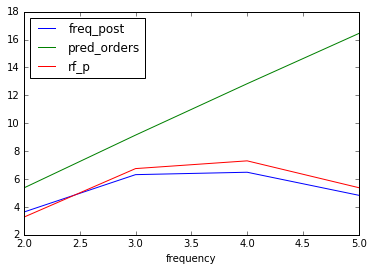

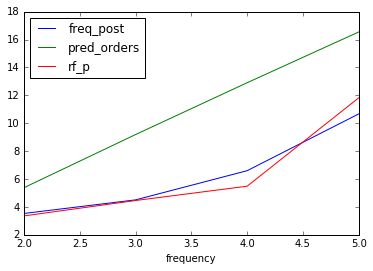

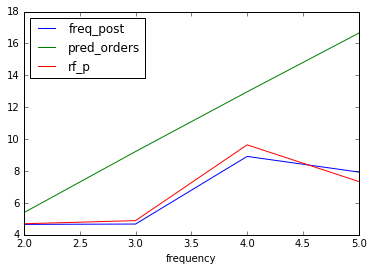

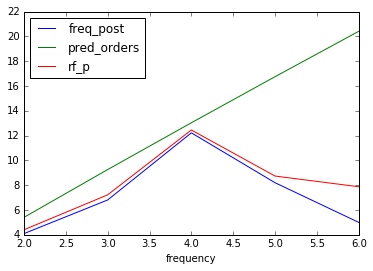

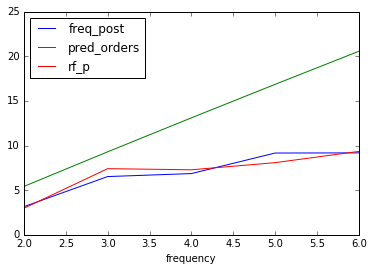

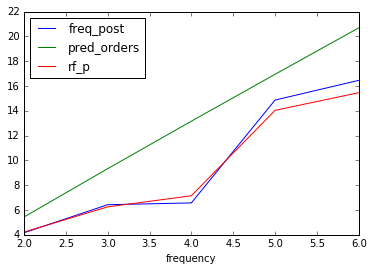

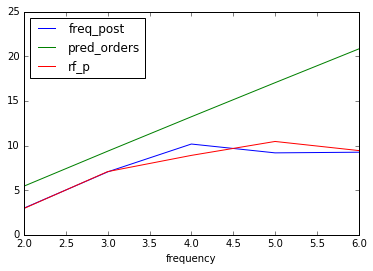

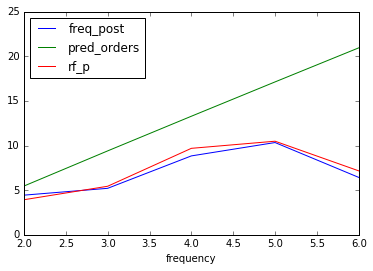

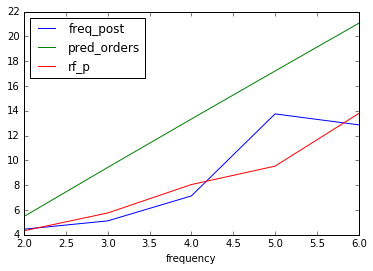

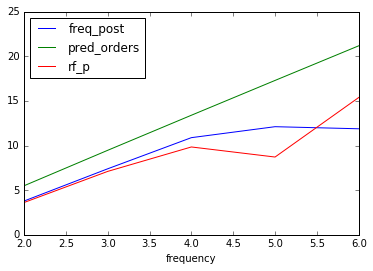

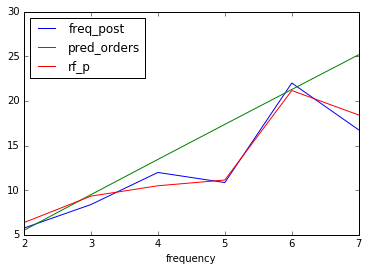

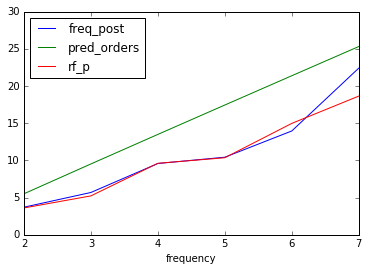

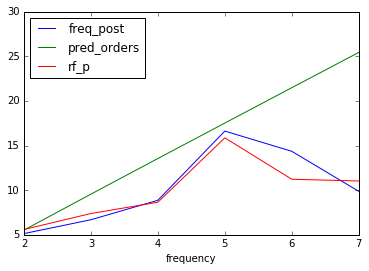

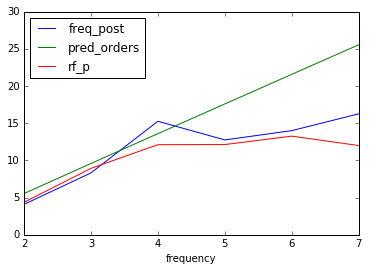

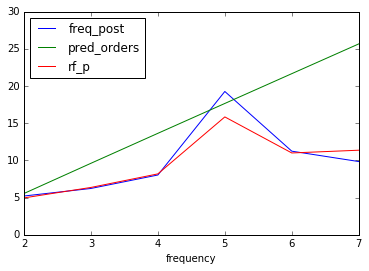

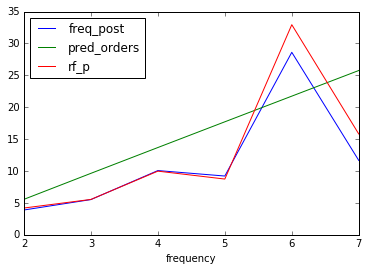

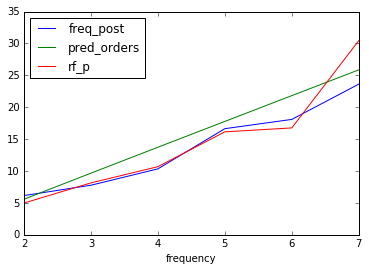

In [115]:
%matplotlib inline
#plot across recency buckets
(data_rft
#.query('tenure_score == 4')
.query('frequency > 1')
.groupby('r_weeks')
.plot(x = 'frequency', y = ['freq_post', 'pred_orders','rf_p'], by = 'r_weeks')
)

# Gridsearch

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from sklearn import cross_validation
from sklearn import metrics
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

n_est = 300


tuned_parameters = {
    "n_estimators": [ n_est ]
    #,
    #"max_depth" : [ 4 ],
    #"learning_rate": [ 0.01 ],
    #"min_samples_split" : [ 1 ],
    #"loss" : [ 'ls', 'lad' ]
}

#gbr = ensemble.GradientBoostingRegressor()
gbr = ensemble.RandomForestRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

In [ ]:
abs(clf.best_score_)

In [ ]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

#Grid search using spark

In [ ]:
import pandas.indexes.base
import pandas.indexes

In [ ]:
from pyspark import SparkContext, SparkConf
from spark_sklearn import GridSearchCV

n_est = 1


tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()


tuned_parameters = {
    "n_estimators": [ n_est ]
    #,
    #"max_depth" : [ 4 ],
    #"learning_rate": [ 0.01 ],
    #"min_samples_split" : [ 1 ],
    #"loss" : [ 'ls', 'lad' ]
}

#gbr = ensemble.GradientBoostingRegressor()
gbr = ensemble.RandomForestRegressor()

#conf = SparkConf()
#sc = SparkContext(conf=conf)
clf = GridSearchCV(sc, gbr, cv=3, param_grid=tuned_parameters, scoring='median_absolute_error')

preds = clf.fit(X_train.values, y_train.values)
best = clf.best_estimator_
best

#abs(clf.best_score_)

In [ ]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

In [ ]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

# Spark based random forest scoring using Mllib

In [117]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [ ]:
conf_start_time=time.time()
confList = [
    ["spark.streaming.unpersist", "true"]           # Automated memory management for Streaming apps
    ,["spark.executor.memory", "32g"]               # Amount of memory for each executor (shared by all tasks in the executor)
    ,["spark.mesos.coarse", "true"]                 # Accept and hold a fixed amount of resource from Mesos
    ,["spark.serializer","org.apache.spark.serializer.KryoSerializer"] #Define Kryo as Base Serializer
    ,["spark.kryoserializer.buffer","128k"]         #Define base memory per node
    ,["spark.kryoserializer.buffer.max.mb","2047"]  #Define max value that Kryo Serializer can run upto
    ,["spark.rdd.compress", "true"]                 # Enabling RDD compress to optimize storeage space
    ,["spark.cores.max", "64"]                      # Defines the number of cores
    ,["spark.akka.heartbeat.interval", "10000s"]     # Define hearbeat pulse interval
    ,["spark.akka.heartbeat.pauses", "15000s"]       # Define hearbeat wait time post interval, for which system waits for executor to reply

]

conf = SparkConf().setAppName("Random Forest - CLTV 8.0").setAll(confList)
sc = SparkContext(conf=conf)
sqlContext = HiveContext(sc)
conf_end_time=time.time()
conf_setup_time=conf_end_time-conf_start_time
print ("Took %.2f to setup start resources on Spark!" %conf_setup_time)

In [ ]:
#Change the dataframe and include new column with features which is basically vector
assembler = VectorAssembler(
  inputCols=["tenure_score", "frequency", "r","pred_orders","tab_smartphone_arr",
             "desktop_arr","other_dev_arr","others_mv_arr"], outputCol="features"
)

assembled = assembler.transform(df)

scaler = StandardScaler(
  inputCol="features", outputCol="scaledFeatures",
  withStd=True, withMean=False
).fit(assembled)

In [ ]:
#Start Random Forest Regression
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(transformed)

#Set data to divide into training and test, here it is 70% and 30%
(trainingData, testData) = transformed.randomSplit([0.7, 0.3])

#Define Indexer
rf = RandomForestRegressor(featuresCol="indexedFeatures",labelCol="freq_post")
pipeline = Pipeline(stages=[featureIndexer, rf])

In [ ]:
# Train model.  This also runs the indexer set above.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.show(5)

In [ ]:
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="repeat_order_cnt", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

rfModel = model.stages[1]
print(rfModel)  # summary only